# Home Work 1


## Description.

Apply your knowledge about Fully-Connected NNs so far to solve several classification tasks


## Evaluation.

Along with every graded task you will see the maximum grading possible for it placed in (parenthesis). Grade might be lowered. The clear indicator that you won't get a maximum amount of points for a task is that your code does not work and/or your NN is not training. In order to obtain the maximum points you have to have sufficient accuracy >90%


### Good luck!

In [ ]:
import numpy as np
import torch
from torch import nn
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import tqdm
import copy

## Data

This is a toy dataset. <br>
$x \in \mathbb{R}^2, y \in \{0, 1\}$

In [ ]:
def load_data(n_samples=500):
    return make_gaussian_quantiles(
        mean=None,
        cov=0.7,
        n_samples=n_samples,
        n_features=2,
        n_classes=2,
        shuffle=True,
        random_state=42,
    )

In [ ]:
gaussian_quantiles = load_data()
X, y = gaussian_quantiles

print(X[:10, :])
print(y[:10])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

[[-1.13773727  0.62436053]
 [-0.75970745 -1.18161805]
 [-0.82471758  0.42171557]
 [-0.09398039 -0.18487643]
 [-0.80731289  0.57399183]
 [ 0.67980788  1.13471182]
 [-1.70521733 -0.84342552]
 [ 1.57461467  1.12565917]
 [-0.22579357 -0.81889248]
 [ 0.97317262  0.00856159]]
[1 1 0 0 1 1 1 1 0 1]


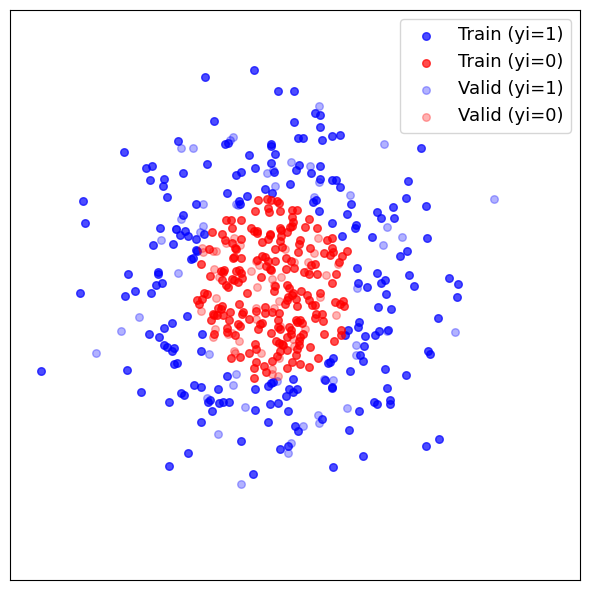

In [ ]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_data(X, y, xy_labels=True, label=None, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    if label is not None:
        plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=label + " (yi=1)", **kwargs)
        plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=label + " (yi=0)", **kwargs)
    plt.xticks(())
    plt.yticks(())
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

plt.figure(figsize=(6, 6))
plot_data(X_train, y_train, alpha=0.7, label="Train")
plot_data(X_test, y_test, alpha=0.3, label="Valid")
plt.legend(fontsize=13)
plt.tight_layout()

## NN declaration (1 points)

You need to implement a class for a simple FC NN. Add as many layers and as many neurons as you'd like.

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, s_in, s2, s3, s4, s5, s_out):
        super(NeuralNetwork, self).__init__()
        self.l1 = nn.Linear(s_in, s2)
        self.a1 = nn.LeakyReLU()
        self.l2 = nn.Linear(s2, s3)
        self.a2 = nn.LeakyReLU()
        self.l3 = nn.Linear(s3, s4)
        self.a3 = nn.LeakyReLU()
        self.l4 = nn.Linear(s4, s5)
        self.a4 = nn.LeakyReLU()
        self.out = nn.Linear(s5, s_out)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.a1(self.l1(x))
        x = self.a2(self.l2(x))
        x = self.a3(self.l3(x))
        x = self.a4(self.l4(x))
        x = self.sig(self.out(x))

        return x

##  Train function. (1.5 points)
Add missing parts

In [ ]:
import tqdm
import copy
def train(model, loss_fn, opt,
          n_epochs, batch_size,
          X_train, y_train, X_val=None, y_val=None):

    x_train_loader = DataLoader(X_train, batch_size=batch_size)
    y_train_loader = DataLoader(y_train, batch_size=batch_size)
    x_val_ld = X_val if X_val is not None else None
    y_val_ld = y_val if y_val is not None else None

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None
    #preds_history = []
    batch_start = torch.arange(0, len(X_train), batch_size)
    loss_list = []
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                for X_batch, y_batch in zip(x_train_loader, y_train_loader):
                    y_pred = model(X_batch)
                    #y_batch = y_batch.view(-1, 1)
                    loss = loss_fn(y_pred, y_batch)
                    opt.zero_grad()
                    loss.backward()
                    opt.step()
                    acc = (y_pred.round() == y_batch).float().mean()
                    bar.set_postfix(
                        loss=float(loss),
                        acc=float(acc)
                    )

            loss_list.append(loss.item())
        # evaluate accuracy at end of each epoch
        if X_val is not None and y_val is not None:
            model.eval()
            y_pred = model(X_val)
            acc = (y_pred.round() == y_val).float().mean()
            acc = float(acc)
            if acc > best_acc:
                best_acc = acc
                best_weights = copy.deepcopy(model.state_dict())
            if acc > 0.98:
                break
    # restore model and return best accuracy

    model.load_state_dict(best_weights)

    return model, best_acc, loss_list

### Train the network. (1 point)

Train NN three times: with three different optimization algorithms. Don't forget to reinitialize model before each train. Make sure you pass the correct arguments to opt.

**Hint** It is better to have three different objects - model1, model2, and model3

In [ ]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float().view(-1, 1)
X_valid_torch = torch.from_numpy(X_test).float()
y_valid_torch = torch.from_numpy(y_test).float().view(-1, 1)

model1 = NeuralNetwork(s_in = 2, s2 = 50, s3 = 25, s4 = 15, s5 = 5, s_out = 1)
model2 = NeuralNetwork(s_in = 2, s2 = 50, s3 = 25, s4 = 15, s5 = 5, s_out = 1)
model3 = NeuralNetwork(s_in = 2, s2 = 50, s3 = 25, s4 = 15, s5 = 5, s_out = 1)

trained_model_SGD, best_acc_SGD, loss_SGD = train(
    model1,
    nn.BCELoss(),
    (torch.optim.SGD(model1.parameters(), lr=0.01)),
    n_epochs=10,
    batch_size=10,
    X_train=X_train_torch,
    y_train=y_train_torch,
    X_val=X_valid_torch,
    y_val=y_valid_torch
    )
print(best_acc_SGD)

trained_model_Adam, best_acc_Adam, loss_Adam = train(
    model2,
    nn.BCELoss(),
    (torch.optim.Adam(model2.parameters(), lr=0.0001)),
    n_epochs=10,
    batch_size=10,
    X_train=X_train_torch,
    y_train=y_train_torch,
    X_val=X_valid_torch,
    y_val=y_valid_torch
    )
print(best_acc_Adam)

trained_model_RMSprop, best_acc_RMSprop, loss_rmsprop = train(
    model3,
    nn.BCELoss(),
    (torch.optim.RMSprop(model3.parameters(), lr=0.0001)),
    n_epochs=10,
    batch_size=10,
    X_train=X_train_torch,
    y_train=y_train_torch,
    X_val=X_valid_torch,
    y_val=y_valid_torch
    )
print(best_acc_RMSprop)


Epoch 2: 100%|██████████| 40/40 [00:07<00:00,  5.40batch/s, acc=1, loss=0.0994]


1.0


Epoch 0: 100%|██████████| 40/40 [00:09<00:00,  4.29batch/s, acc=1, loss=0.144]


0.9800000190734863


Epoch 1: 100%|██████████| 40/40 [00:08<00:00,  4.94batch/s, acc=1, loss=0.0711]

0.9800000190734863


### А теперь посмотрим на графики лоссов

In [ ]:
loss_rmsprop

[0.31327003240585327, 0.07114505767822266]

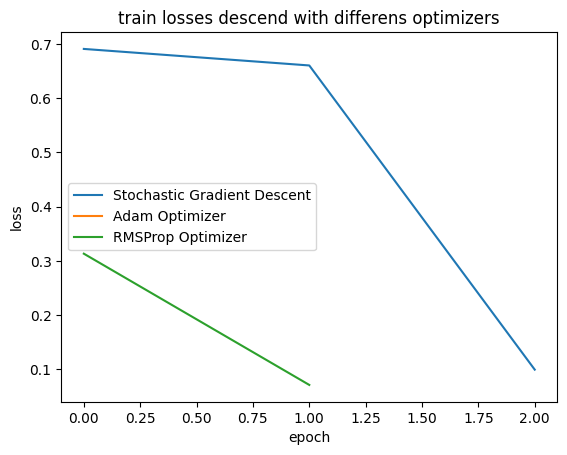

In [ ]:
plt.plot(loss_SGD, label = "Stochastic Gradient Descent")
plt.plot(loss_Adam, label = "Adam Optimizer")
plt.plot(loss_rmsprop, label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('train losses descend with differens optimizers')
plt.show()

## Now solve multi-class task (2.5 points)

You are welcome to use anything you know.


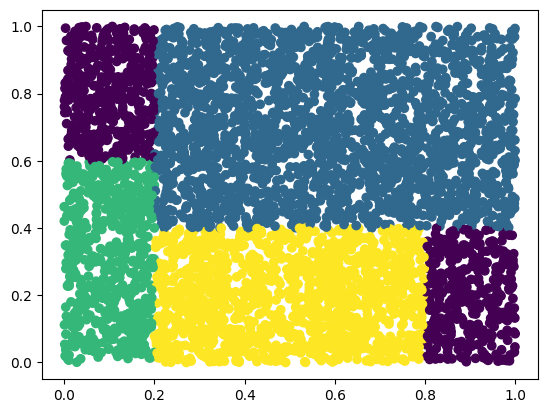

In [ ]:
points = torch.rand(5000,2)
target = []
for p in points:
    if p[0]>0.2 and p[1]>0.4:
        target.append(1)
    elif p[0]<0.2 and p[1]<0.6:
        target.append(2)
    elif p[0]>0.2 and p[0]<0.8 and p[1] < 0.5:
        target.append(3)
    else:
        target.append(0)

target = torch.FloatTensor(target)
data = torch.as_tensor(np.column_stack((points,target)))

train = data[:800]
valid = data[800:900]
test = data[900:]

plt.scatter(data[:,0],data[:,1],c = data[:,2])
plt.show()

In [ ]:
torch.unique(data[:, 2])

tensor([0., 1., 2., 3.])

In [ ]:
class AdvancedModel(nn.Module):
    def __init__(self, s_in, s2, s3, s4, s5, s_out):
        '''s_in = 2, s_out = 4'''
        super(AdvancedModel, self).__init__()
        self.l1 = nn.Linear(s_in, s2)
        self.a1 = nn.LeakyReLU()
        self.l2 = nn.Linear(s2, s3)
        self.a2 = nn.LeakyReLU()
        self.l3 = nn.Linear(s3, s4)
        self.a3 = nn.LeakyReLU()
        self.l4 = nn.Linear(s4, s5)
        self.a4 = nn.LeakyReLU()
        self.out = nn.Linear(s5, s_out)


    def forward(self, x):
        x = self.a1(self.l1(x))
        x = self.a2(self.l2(x))
        x = self.a3(self.l3(x))
        x = self.a4(self.l4(x))
        x = self.out(x)

        return x


In [ ]:
def train_model(model, loss_fn, opt, n_epochs, batch_size, X_train, y_train, X_val, y_val):
    x_train_loader = DataLoader(X_train, batch_size=batch_size)
    y_train_loader = DataLoader(y_train, batch_size=batch_size)

    # Hold the best model
    best_acc = - np.inf   # init to negative infinity
    best_weights = None
    #preds_history = []
    batch_start = torch.arange(0, len(X_train), batch_size)
    multi_loss_list = []
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                for X_batch, y_batch in zip(x_train_loader, y_train_loader):
                    y_pred = model(X_batch)
                    #y_batch = y_batch.view(-1, 1)
                    loss = loss_fn(y_pred, y_batch.long())
                    opt.zero_grad()
                    loss.backward()
                    opt.step()
                    acc = (torch.argmax(y_pred, dim = 1) == y_batch).float().mean()
                    bar.set_postfix(
                        loss=float(loss),
                        acc=float(acc)
                    )

            multi_loss_list.append(loss.item())
        # evaluate accuracy at end of each epoch
        if X_val is not None and y_val is not None:
            model.eval()
            y_pred = model(X_val)
            acc = (torch.argmax(y_pred, dim = 1) == y_val).float().mean()
            acc = float(acc)
            if acc > best_acc:
                best_acc = acc
                best_weights = copy.deepcopy(model.state_dict())
            if acc > 0.98:
                break
    # restore model and return best accuracy

    model.load_state_dict(best_weights)

    return model, best_acc, multi_loss_list

In [ ]:
X_train = train[:, 0:2]
X_val = valid[:, 0:2]
X_test = test[:, 0:2]

y_train = train[:, 2]
y_val = valid[:, 2]
y_test = test[:, 2]

In [ ]:
model_m1 = AdvancedModel(s_in = 2, s2 = 50, s3 = 25, s4 = 15, s5 = 5, s_out = 4)
model_m2 = AdvancedModel(s_in = 2, s2 = 50, s3 = 25, s4 = 15, s5 = 5, s_out = 4)
model_m3 = AdvancedModel(s_in = 2, s2 = 50, s3 = 25, s4 = 15, s5 = 5, s_out = 4)

multi_trained_model_SGD, multi_best_acc_SGD, multi_loss_SGD = train_model(
    model_m1,
    nn.CrossEntropyLoss(),
    (torch.optim.SGD(model_m1.parameters(), lr=0.01)),
    n_epochs=20,
    batch_size=25,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
    )
print(multi_best_acc_SGD)

multi_trained_model_Adam, multi_best_acc_Adam, multi_loss_Adam = train_model(
    model_m2,
    nn.CrossEntropyLoss(),
    (torch.optim.Adam(model_m2.parameters(), lr=0.001)),
    n_epochs=10,
    batch_size=25,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
    )
print(multi_best_acc_Adam)

multi_trained_model_RMSprop, multi_best_acc_RMSprop, multi_loss_rmsprop = train_model(
    model_m3,
    nn.CrossEntropyLoss(),
    (torch.optim.RMSprop(model_m3.parameters(), lr=0.001)),
    n_epochs=10,
    batch_size=25,
    X_train=X_train,
    y_train=y_train,
    X_val=X_val,
    y_val=y_val
    )
print(multi_best_acc_RMSprop)

Epoch 11: 100%|██████████| 32/32 [00:05<00:00,  6.18batch/s, acc=1, loss=0.167]


0.9900000095367432


Epoch 0: 100%|██████████| 32/32 [00:07<00:00,  4.54batch/s, acc=0.96, loss=0.172]


0.9900000095367432


Epoch 9: 100%|██████████| 32/32 [00:06<00:00,  5.18batch/s, acc=0.96, loss=0.0457]

0.9800000190734863


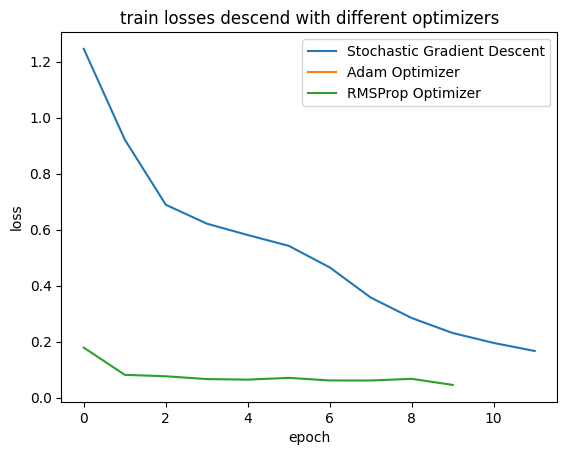

In [ ]:
plt.plot(multi_loss_SGD, label = "Stochastic Gradient Descent")
plt.plot(multi_loss_Adam, label = "Adam Optimizer")
plt.plot(multi_loss_rmsprop, label = 'RMSProp Optimizer')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.title('train losses descend with different optimizers')
plt.show()

In [ ]:
print('test_eval')
print('SGD')
y_pred_SGD = model_m1(X_test)
acc = (torch.argmax(y_pred_SGD, dim = 1) == y_test).float().mean()
print(acc)

print('Adam')
y_pred_Adam = model_m2(X_test)
acc = (torch.argmax(y_pred_Adam, dim = 1) == y_test).float().mean()
print(acc)

print('RMSProp')
y_pred_RMSProp = model_m3(X_test)
acc = (torch.argmax(y_pred_RMSProp, dim = 1) == y_test).float().mean()
print(acc)

test_eval
SGD
tensor(0.9539)
Adam
tensor(0.9578)
RMSProp
tensor(0.9783)


норм

## (Almost) Real task. (4 points)

This is alcohol classification task. You need to predict the target value.
Feel free to visualize and do whatever feels right to EDA and training model.
You can reuse previous models with slight changes or make a new one

Так, нужно сделать мультиклассификацию на предсказание абстрактного таргета по 13 переменным

In [ ]:
df = sklearn.datasets.load_wine(as_frame=True)
df = df.frame
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [ ]:
df.dtypes

alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
target                            int64
dtype: object

In [ ]:
df['target'].unique()

array([0, 1, 2])

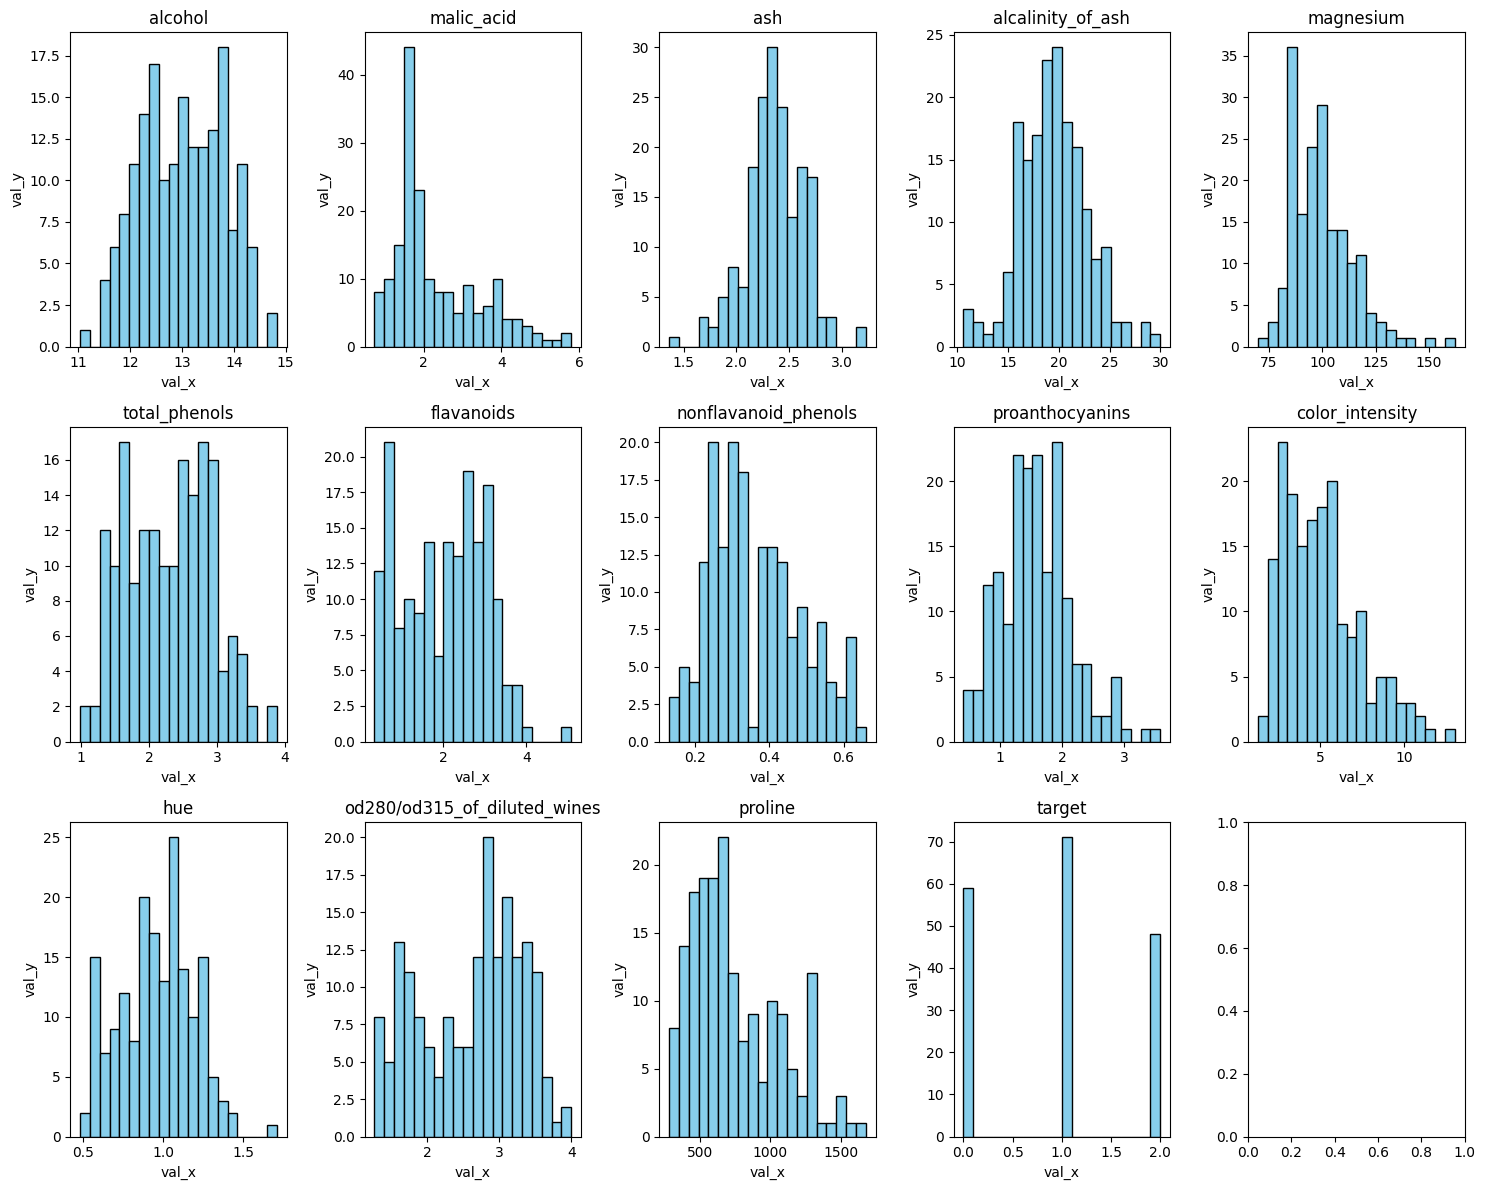

In [ ]:
fig, axs = plt.subplots(3, 5, figsize = (15, 12))
for i, column in enumerate(df.columns):
    row = i // 5
    col = i % 5
    axs[row, col].hist(df[column], bins=20, color='skyblue', edgecolor='black')
    axs[row, col].set_title(f'{column}')
    axs[row, col].set_xlabel('val_x')
    axs[row, col].set_ylabel('val_y')

plt.tight_layout()
plt.show()

In [ ]:
x = df.drop('target', axis = 1)
y = df['target']


In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 27)

scaler = MinMaxScaler(feature_range = (0, 1))
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.fit_transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

X_train_tens = torch.tensor(X_train_sc, dtype=torch.float32)
X_test_tens = torch.tensor(X_test_sc, dtype=torch.float32)
y_train_tens = torch.tensor(y_train, dtype=torch.float32)
y_test_tens = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
#model
class UltraModel(nn.Module):
    def __init__(self, s2, s3, s4, s5):
        super(UltraModel, self).__init__()
        self.l1 = nn.Linear(13, s2)
        self.a1 = nn.LeakyReLU()
        self.dropout_1 = nn.Dropout(0.2)
        self.l2 = nn.Linear(s2, s3)
        self.a2 = nn.LeakyReLU()
        self.l3 = nn.Linear(s3, s4)
        self.a3 = nn.LeakyReLU()
        self.dropout_2 = nn.Dropout(0.2)
        self.l4 = nn.Linear(s4, s5)
        self.a4 = nn.LeakyReLU()
        self.out = nn.Linear(s5, 3)


    def forward(self, x):
        x = self.a1(self.l1(x))
        x = self.dropout_1(x)
        x = self.a2(self.l2(x))
        x = self.a3(self.l3(x))
        x = self.dropout_2(x)
        x = self.a4(self.l4(x))
        x = self.out(x)

        return x

In [ ]:
# helper traain func and CV because of small data
def train_model(model, loss_fn, learn_r, n_epochs, batch_size, X_train, y_train, X_val, y_val):
    x_train_loader = DataLoader(X_train, batch_size=batch_size)
    y_train_loader = DataLoader(y_train, batch_size=batch_size)

    best_acc = - np.inf
    best_weights = None
    opt = torch.optim.Adam(model.parameters(), lr=learn_r)
    batch_start = torch.arange(0, len(X_train), batch_size)
    for epoch in range(n_epochs):
        model.train()
        with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=False) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                for X_batch, y_batch in zip(x_train_loader, y_train_loader):
                    y_pred = model(X_batch)
                    #y_batch = y_batch.view(-1, 1)
                    loss = loss_fn(y_pred, y_batch.long())
                    opt.zero_grad()
                    loss.backward()
                    opt.step()
                    acc = (torch.argmax(y_pred, dim = 1) == y_batch).float().mean()
                    bar.set_postfix(
                        loss=float(loss),
                        acc=float(acc)
                    )

        if X_val is not None and y_val is not None:
            model.eval()
            y_pred = model(X_val)
            acc = (torch.argmax(y_pred, dim = 1) == y_val).float().mean()
            acc = float(acc)
            if acc > best_acc:
                best_acc = acc
                best_weights = copy.deepcopy(model.state_dict())
            if acc > 0.98:
                break

    model.load_state_dict(best_weights)

    return model, best_acc

In [ ]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=27)
accuracies = []
for train, test in kfold.split(X_train_sc, y_train):
    X_train_fold, X_test_fold = X_train_tens[train], X_train_tens[test]
    y_train_fold, y_test_fold = y_train_tens[train], y_train_tens[test]
    model = UltraModel(s2 = 50, s3 = 25, s4 = 15, s5 = 7)
    tr_model, fold_acc = train_model(model, loss_fn = nn.CrossEntropyLoss(),
                                     learn_r = 0.001, n_epochs = 50, batch_size = 15,
                                     X_train = X_train_fold, y_train = y_train_fold,
                                     X_val = X_test_fold, y_val = y_test_fold
                                     )
    print("Accuracy: %.2f" % fold_acc)
    accuracies.append(fold_acc)

mean = np.mean(accuracies)
std = np.std(accuracies)
print("Baseline: %.2f%% (+/- %.2f%%)" % (mean*100, std*100))

Epoch 5: 100%|██████████| 7/7 [00:00<00:00, 24.19batch/s, acc=1, loss=0.0697]


Accuracy: 1.00


Epoch 3: 100%|██████████| 7/7 [00:00<00:00, 23.74batch/s, acc=0.778, loss=0.415]


Accuracy: 1.00


Epoch 4: 100%|██████████| 7/7 [00:00<00:00, 22.98batch/s, acc=0.889, loss=0.2]


Accuracy: 1.00


Epoch 6: 100%|██████████| 7/7 [00:00<00:00, 19.75batch/s, acc=0.889, loss=0.178]


Accuracy: 1.00


Epoch 11: 100%|██████████| 7/7 [00:00<00:00, 23.75batch/s, acc=1, loss=0.00508]

Accuracy: 1.00
Baseline: 100.00% (+/- 0.00%)


In [ ]:
accuracies

[1.0, 1.0, 1.0, 1.0, 1.0]

In [ ]:
model_test = UltraModel(s2 = 50, s3 = 25, s4 = 15, s5 = 7)
tr_model, acc = train_model(model_test, loss_fn = nn.CrossEntropyLoss(),
                            learn_r = 0.001, n_epochs = 50, batch_size = 15,
                            X_train = X_train_tens, y_train = y_train_tens,
                            X_val = X_test_tens, y_val = y_test_tens
                            )
print(acc)

Epoch 2: 100%|██████████| 9/9 [00:00<00:00, 19.19batch/s, acc=1, loss=0.108]


0.9814814925193787


Источники:      
https://pytorch.org/docs/stable/generated/torch.unique.html     
https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/        
https://discuss.pytorch.org/t/why-the-output-of-my-model-is-none/20703      
https://pytorch.org/docs/stable/generated/torch.argmax.html     
https://chat.openai.com     
https://machinelearningmastery.com/using-dropout-regularization-in-pytorch-models/      
